Confronting my b&ecirc;te noire, the particle filter
=====

I have a dysfunctional relationship with [particle filters][pf].

I know
that in theory,
given enough time,
they can solve a huge variety of interesting problems,
and for low-dimensional problems,
they don't even need that much time.
But, until this notebook, I had never implemented one,
even for the simplest problem.
So I am in the unappealing position
of appealing to miracles from an algorithm
I don't understand well enough to use in practice.

For example,
in [Particle Filter Noise Encoder](./particle-filter-noise-encoder.ipynb),
I declare that they should be able to provide absolute shaft encoding
from a single sensor positioned over a noise track,
and in [Particle filtering to demodulate fake Kansas City Standard variant signals](./particle-filtering-kansas-city.ipynb),
I declare that they ought to be better at decoding
old data cassette tapes
than standard DSP algorithms.
But having tried neither of these in practice,
they amount to little more than idle speculation.
Neither of those notebooks contains an actual implemented particle filter yet.

[pf]: https://en.wikipedia.org/wiki/Particle_filter

So what's the simplest possible particle filter?
Maybe we have a particle moving at a constant, known velocity
along a one-dimensional cyclic space
which has a known, varying brightness
and we want to estimate where it is
from noisy observations of the brightness.

So I finally implemented such a filter — in this notebook, below.
Perhaps it will be of interest to somebody else trying to figure this
stuff out.

Setting up the problem
---------------------------------

In [1]:
%pylab inline
import scipy.stats
rcParams['figure.figsize'] = (12, 2)
rcParams['lines.linewidth'] = 0.5

Populating the interactive namespace from numpy and matplotlib


Let's low-pass filter some noise to get the landscape.
If we subtract the mean, we can guarantee the dc component is zero,
so the cumsum should be nicely cyclic.

CPU times: user 24.2 ms, sys: 5.73 ms, total: 29.9 ms
Wall time: 27.6 ms


1.0

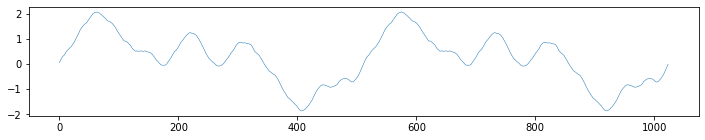

In [2]:
%%time
# Supposedly guarantees reproducibility
rng = random.Generator(random.PCG64(3))
world = rng.normal(size=512)
for i in range(2):
    world = (world - world.mean()).cumsum()

def rms(sig):
    return (sig**2).mean()**.5

world /= rms(world)
plot(world[concatenate((arange(512), arange(512)))])
rms(world)

So now let's pick a starting position and a trajectory
for the particle filter to try to estimate.

CPU times: user 23.6 ms, sys: 3.84 ms, total: 27.5 ms
Wall time: 25.6 ms


(0, 512)

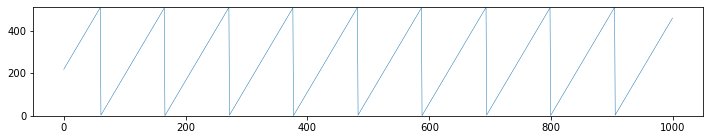

In [3]:
%%time
start = rng.integers(0, len(world), 1)[0]
speed = 1.618 * 3
t = arange(1000)
x = (start + speed * t) % len(world)
plot(x)
ylim(0, len(world))

So now let's make some observations.

CPU times: user 28.4 ms, sys: 78 µs, total: 28.4 ms
Wall time: 26.7 ms


1.0295026783068106

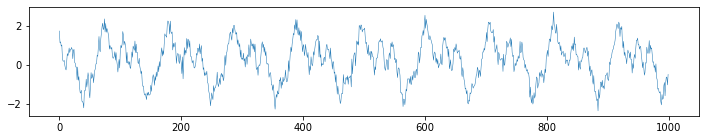

In [4]:
%%time
noise = rng.normal(size=len(x), scale=1/4)
obs_i = x.round().astype(int).clip(0, len(world)-1)
observations = world[obs_i] + noise
plot(observations)
rms(observations)

That certainly looks like a feasible estimation problem to solve,
doesn't it?  Not trivial, but feasible.  You can clearly see
the shape of the landscape under the noise.

Solving it with a particle-filter solution
-------------------------------------------------------

In [5]:
particles = rng.integers(0, len(world), 32)
particles

array([412, 447, 276,  66, 462,  40,  13, 452,   0,  55, 419, 337, 303,
        74, 384, 500, 165, 283, 288, 388,  76, 299,  59, 405, 283, 240,
       435,  75, 277, 447,   8, 164])

So here's our initial distribution of guesses in the world,
along with the actually correct answer,
and our first observation.  We're displaying each particle with a random height
so that many particles in the same place won't look like a single particle.

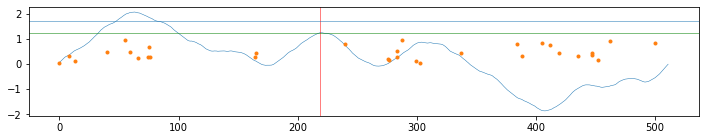

In [6]:
def portray(states, timestep):
    n = len(states)
    plot(world)
    plot(states, rng.random(size=n), '.')
    axvline(x[timestep], color='red')
    axhline(observations[timestep])
    axhline(observations[timestep] - noise[0], color='green')

portray(particles, 0)

The initial observation is high, almost higher than the whole landscape,
because the initial noise value was high:

In [7]:
noise[0]

0.4808210092076473

### Gaussian distributions and the likelihood function ###

What's the probability of such a high value?  We can estimate it
by looking at the actual noise distribution:

In [8]:
(noise >= noise[0]).mean()

0.021

It's about 2%.  But what we actually want for
reweighting the particles is not the cdf (or 1 - cdf)
but the pdf.  `scipy.stats` has stuff in it for that kind of thing,
but I've never used it, so let's see if it works the way I think.

In [9]:
1 - scipy.stats.norm.cdf(noise[0] / (1/4))

0.02722219412045379

That's about 6 samples out of 1000 higher than the empirical value,
which seems pretty reasonable?

In [10]:
scipy.stats.norm.cdf(-2), (noise < -.5).mean()

(0.022750131948179195, 0.02)

In [11]:
scipy.stats.norm.cdf(-1), (noise < -.25).mean()

(0.15865525393145707, 0.154)

Those seem like about the right thing.  And theoretically the pdf
is just the derivative of the cdf:

In [12]:
1000 * (scipy.stats.norm.cdf(noise[0]/.5 + .001)
        - scipy.stats.norm.cdf(noise[0]/.5))

0.25112683014216763

In [13]:
scipy.stats.norm.pdf(noise[0]/.5)

0.25124763841517983

Okay, that seems right.  Here's a plot:

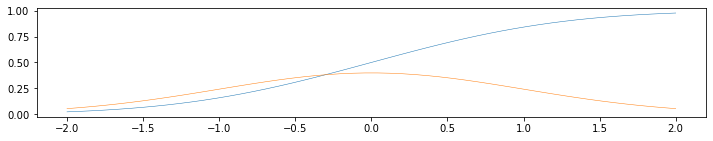

In [14]:
s = linspace(-2, 2)
plot(s, scipy.stats.norm.cdf(s))
plot(s, scipy.stats.norm.pdf(s))
None

### Weighting particles by their likelihood ###

So what we want to do is reweight each particle
by the likelihood of the observation
at the position of that particle.
This is a function (specifically that pdf!)
of the scaled distance.

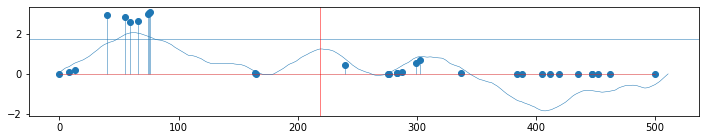

In [15]:
lik = scipy.stats.norm.pdf((world[particles] - observations[0])/.5)

def show_weights(states, weights, timestep):
    stem(states, weights * 8, use_line_collection=True)
    plot(world)
    axhline(observations[timestep])
    axvline(x[timestep], color='red')

show_weights(particles, lik, 0)

That looks pretty terrible; it seems like we're being way too certain
about our observation, and if we resample from that distribution we're going to have a terrible problem.

### Drawing samples from one's posterior ###

Let's do it anyway.

CPU times: user 36.6 ms, sys: 8.85 ms, total: 45.5 ms
Wall time: 38 ms


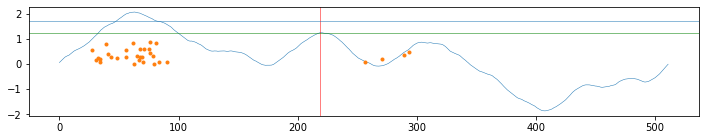

In [16]:
%%time
def samplefrom(discrete_pdf, n):
    discrete_cdf = discrete_pdf.cumsum()
    uniform = rng.random(size=n) * discrete_cdf[-1]
    return searchsorted(discrete_cdf, uniform)

n = len(particles)
jitter = rng.normal(size=n) * 10
particles2 = (particles[samplefrom(lik, n)] + jitter) % len(world)

portray(particles2, 0)

### Reweighting more skeptically ###

That seems like too much certainty
to attach to that initial observation.
Let's try with more epistemic humility,
or Cartesian skepticism about our lying eyes.

array([0.  , 0.01, 0.09, 0.38, 0.01, 0.39, 0.2 , 0.01, 0.1 , 0.39, 0.  ,
       0.14, 0.28, 0.39, 0.  , 0.03, 0.11, 0.13, 0.17, 0.  , 0.4 , 0.26,
       0.38, 0.  , 0.13, 0.24, 0.01, 0.4 , 0.1 , 0.01, 0.15, 0.11])

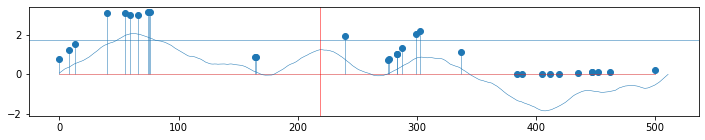

In [17]:
skepticism = 1
lik = scipy.stats.norm.pdf((world[particles] 
                            - observations[0])/skepticism)

show_weights(particles, lik, 0)
lik.round(2)

That seems a little more plausible.  Let's try resampling.
We can use less jitter, too.
As an extra skeptical measure, we'll pick one particle just anywhere.

In [18]:
jitter_size = 4
jitter = rng.normal(size=n) * jitter_size
particles3 = (particles[samplefrom(lik, n)] + jitter) % len(world)
particles3[0] = rng.integers(len(world))

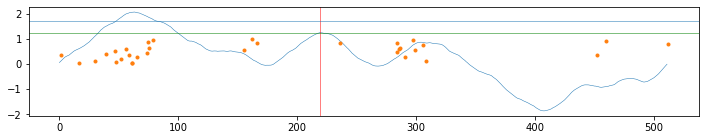

In [19]:
portray(particles3, 0)

### Predicting the system's state transitions ###

Now we want to *predict*: we move the particles at their known velocity.
Here I'm going to plot the particles with random Y-coordinates
because several of them are on top of each other,
so the plot above is sort of misleading.

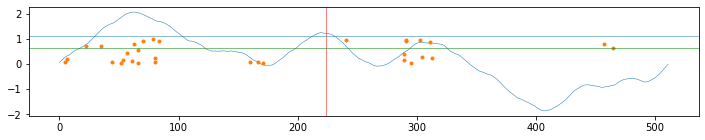

In [20]:
particles4 = particles3 + speed
particles4 = particles4.round().astype(int) % len(world)
portray(particles4, 1)

### A few more time steps, one by one ###

Let's reweight the particles according to the second observation,
which is a less incorrect observation than the first,
as it happens.

array([0.29, 0.35, 0.27, 0.36, 0.28, 0.26, 0.26, 0.39, 0.33, 0.06, 0.34,
       0.37, 0.38, 0.33, 0.32, 0.38, 0.33, 0.33, 0.33, 0.39, 0.39, 0.26,
       0.26, 0.28, 0.23, 0.05, 0.2 , 0.36, 0.3 , 0.32, 0.27, 0.3 ])

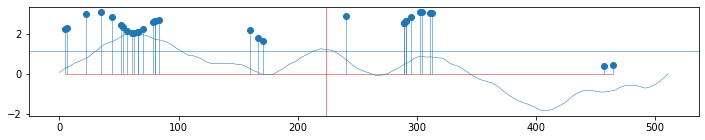

In [21]:
lik = scipy.stats.norm.pdf((world[particles4] 
                            - observations[1])/skepticism)
show_weights(particles4, lik, 1)
lik.round(2)

So let's resample according to that distribution and see what we get.

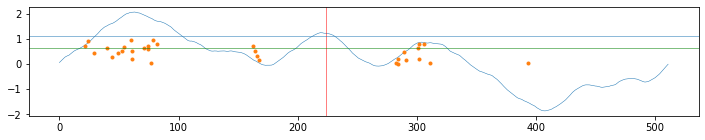

In [22]:
def resample(states, likelihood):
    n = len(states)
    jitter = rng.normal(size=n) * jitter_size
    result = (states[samplefrom(likelihood, n)] + jitter) % len(world)
    result[0] = rng.integers(len(world))
    return result

particles5 = resample(particles4, lik)
portray(particles5, 1)

Now we move them imperceptibly to the right:

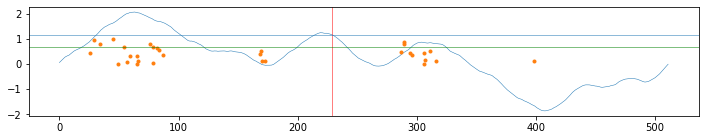

In [23]:
def predict_from(states):
    s = states + speed
    return s.round().astype(int) % len(world)

particles6 = predict_from(particles5)
portray(particles6, 2)

And reweight according to another observation:

(array([0.008, 0.309, 0.397, 0.395, 0.341, 0.318, 0.345, 0.359, 0.334,
        0.374, 0.379, 0.281, 0.202, 0.197, 0.292, 0.309, 0.272, 0.356,
        0.334, 0.272, 0.357, 0.379, 0.272, 0.298, 0.387, 0.19 , 0.209,
        0.336, 0.274, 0.379, 0.379, 0.348]),
 0.009243301868632129)

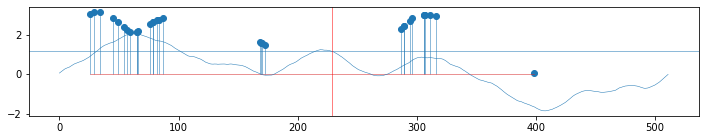

In [24]:
def weights(states, timestep):
    errors = world[states] - observations[timestep]
    return scipy.stats.norm.pdf(errors/skepticism)
    # omitting the normalization-by-sum step
    # because our sampling-by-pdf subroutine does it

lik = weights(particles6, 2)
    
show_weights(particles6, lik, 2)    
lik.round(3), noise[2]

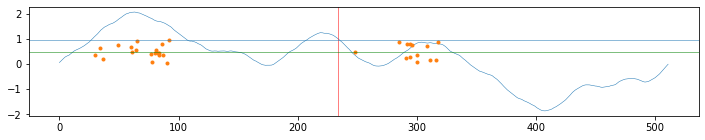

In [25]:
particles7 = predict_from(resample(particles6, lik))
portray(particles7, 3)

(array([0.334, 0.22 , 0.394, 0.376, 0.397, 0.395, 0.376, 0.216, 0.314,
        0.355, 0.279, 0.396, 0.394, 0.366, 0.309, 0.375, 0.216, 0.302,
        0.218, 0.293, 0.322, 0.361, 0.303, 0.289, 0.297, 0.386, 0.396,
        0.396, 0.274, 0.327, 0.303, 0.339]),
 -0.04987293687851771)

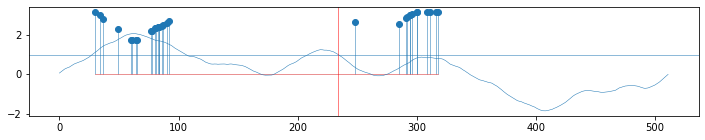

In [26]:
lik = weights(particles7, 3)
show_weights(particles7, lik, 3)
lik.round(3), noise[3]

Another fairly accurate observation, and now we have
maybe a slightly better spread.  Next timestep?

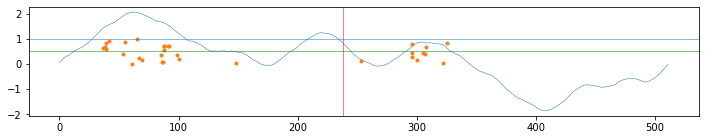

In [27]:
particles8 = predict_from(resample(particles7, lik))
portray(particles8, 4)

(array([0.348, 0.253, 0.229, 0.325, 0.387, 0.393, 0.358, 0.328, 0.269,
        0.394, 0.387, 0.349, 0.375, 0.232, 0.38 , 0.38 , 0.235, 0.328,
        0.344, 0.245, 0.39 , 0.339, 0.354, 0.393, 0.317, 0.395, 0.328,
        0.354, 0.38 , 0.284, 0.32 , 0.363]),
 0.16815288503969283)

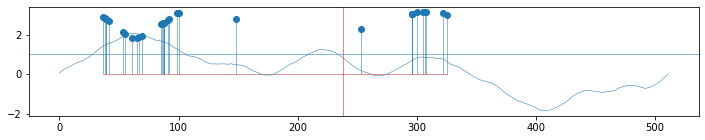

In [28]:
lik = weights(particles8, 4)
show_weights(particles8, lik, 4)
lik.round(3), noise[4]

### Traveling more rapidly through the rest of the timesteps ###

Nothing too ridiculous so far.  Let's try for 8 more timesteps.

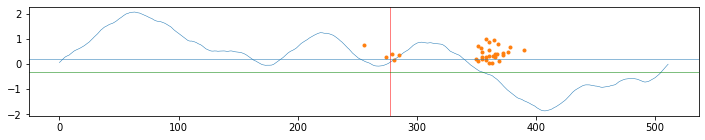

In [29]:
pn = particles8
for ts in range(4, 13):
    pn = predict_from(resample(pn, weights(pn, ts)))

portray(pn, 12)

Well, that doesn't look super healthy.  But it does seem like the clump
that was to the right of the true position is sort of creeping toward it,
and the other initially-dominant clump from the mountain has died off.

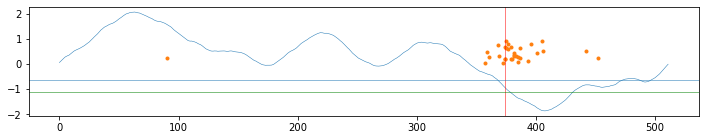

In [30]:
for ts in range(13, 33):
    pn = predict_from(resample(pn, weights(pn, ts)))

portray(pn, 32)

That looks pretty good actually!

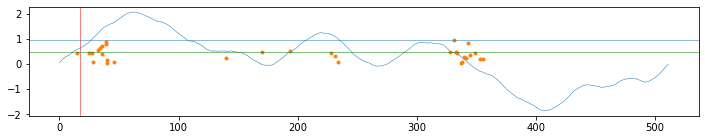

In [31]:
for ts in range(33, 65):
    pn = predict_from(resample(pn, weights(pn, ts)))

portray(pn, 64)

That's even better!

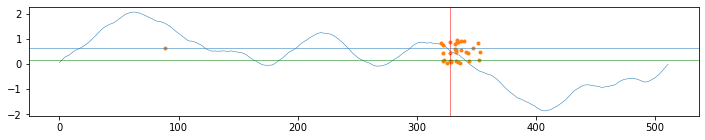

In [32]:
timesteps = []
histories = [[] for i in range(len(pn))]
for ts in range(65, 129):
    pn = predict_from(resample(pn, weights(pn, ts)))
    timesteps.append(ts)
    for j, pj in enumerate(pn):
        histories[j].append(pj)   

portray(pn, 128)

That also looks pretty acceptable.  Here's how it evolved over time;
the time dimension is vertical and the space dimension is horizontal
in this plot, so the horizontal scale is the same as above.
The true X-position is drawn as a thick red line.

In [33]:
t128 = timesteps[:]
h128 = [hi[:] for hi in histories]

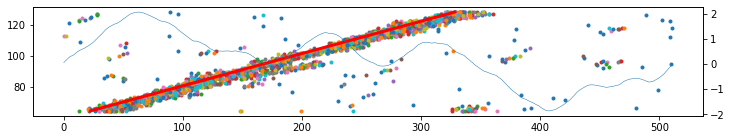

In [34]:
for i, hi in enumerate(h128):
    plot(hi, t128, '.')
plot(x[t128], t128, linewidth=3, color='red')

gca().twinx()
_ =plot(world)

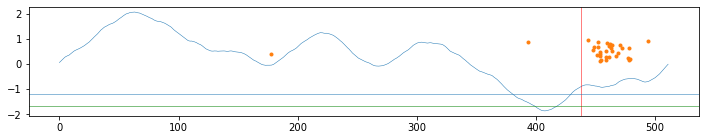

In [35]:
for ts in range(129, 257):
    pn = predict_from(resample(pn, weights(pn, ts)))
    timesteps.append(ts)
    for j, pj in enumerate(pn):
        histories[j].append(pj)

portray(pn, 256)

Hmm, that doesn't look quite right.  Let's look at the whole history.
This time we have to swap the axes.

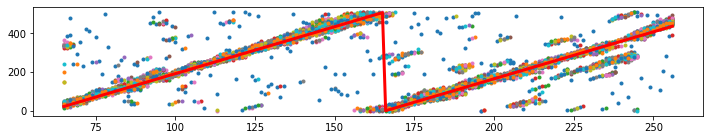

In [36]:
for i, hi in enumerate(histories):
    plot(timesteps, hi, '.')
    
_ = plot(timesteps, x[timesteps], linewidth=3, color='red')

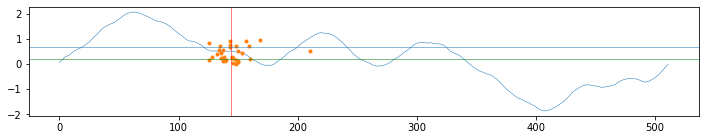

In [37]:
for ts in range(257, 513):
    pn = predict_from(resample(pn, weights(pn, ts)))
    timesteps.append(ts)
    for j, pj in enumerate(pn):
        histories[j].append(pj)

portray(pn, 512)

What, now it's converging on a reasonable estimate?
Maybe not a very precise one, but still?
Let's plot its CDF.

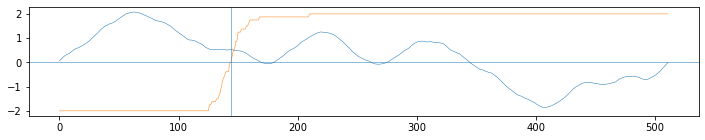

In [38]:
pn512 = pn.copy()
plot(world)
xs = arange(len(world))
plot(xs, [4*(pn512 <= xi).sum()/len(pn512)-2 for xi in xs])
axvline((start + speed * 512) % len(world))
_ = axhline(0)

I guess that's okay.

### The final results are OK ###

In [39]:
%%time
for ts in range(513, 1000):
    pn = predict_from(resample(pn, weights(pn, ts)))
    timesteps.append(ts)
    for j, pj in enumerate(pn):
        histories[j].append(pj)

CPU times: user 229 ms, sys: 71 ms, total: 300 ms
Wall time: 195 ms


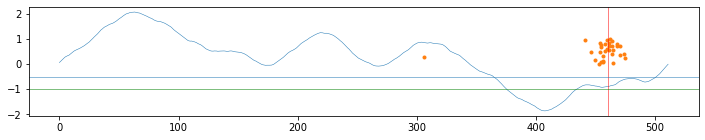

In [40]:
portray(pn, 999)

It never converges to anything reasonably precise, though it does do a good job of tracking
the true position eventually.  But hey!  At least it's dog-slow!

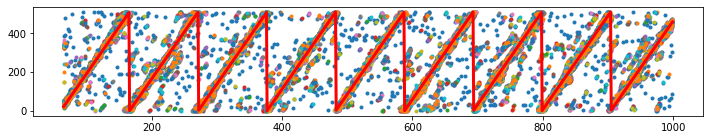

In [41]:
for i, hi in enumerate(histories):
    plot(timesteps, hi, '.')

_ = plot(timesteps, x[timesteps], linewidth=3, color='red')

Reflections
-----

I had a few different bugs as I wrote this code that made it take a long time
to get working at all.

One was that my prediction step wasn't wrapping around properly;
my particles would get squished up against the right edge of the world
because I was clipping their position to `len(world)-1`.
It's a miracle it worked as well as it did,
given that the only way for a particle to get from the right side of the world
to the left side
was to jitter onto the left side.
However, I also observed a systematic tendency
for the cluster of particles to be to the *right* of the true position,
and I still don't know why that happened.

Another was that I wasn't using my `skepticism` parameter
because I copied and pasted the code $n$ times,
then replaced the constant with a variable $n-1$ times,
and the remaining time was the one I was using in almost all the timesteps.
So most of the time the code was being far too skeptical of its observations
(I was dividing by 8)
and so had a hard time getting the particles to clump into a nice tight estimate,
because the Gaussian it was weighting by had a peak that was far too broad.

On the other hand,
the Gaussian isn't very fat-tailed,
and so, while it was pretty skeptical about the exact values of its observations,
it was far too certain about the general vicinity in which the state could be found.
This frequently led to sample impoverishment and filter divergence.
The hack of choosing *one* particle with a uniformly random state at every timestep
has been extremely helpful in making it more robust.

There are three ad-hoc parameters in the above code: `skepticism`, `jitter_size`,
and the number of particles.  The third is sort of easy to choose:
no value is too big, and you'll always get better results with more particles.
The other two are not, and it's easy to get the filter to diverge
by choosing the wrong values, though sometimes you can get it to converge again
by boosting the number of particles.

Too much skepticism or too much jitter tends to result in a more diffuse clump
of particles around the true position.  Too little tends to result in divergence.

The initial observation or two is in effect given far too much weight:
we start with a uniform distribution, but it becomes very nonuniform after even
a single observation, greatly reducing the diversity of states.  As it happens,
in the above example, the first observation is a 97th-percentile kind of error,
or I guess 95th percentile using a two-tailed criterion,
so the filter starts its life pretty deluded.  I can empathize!

This code has only 512 possible states for a particle,
so it would probably be better to use a [*histogram filter*][hf],
in which we track the probability of being in each of those states.
32 bins would probably be enough.
The whole sampling foofaraw isn't very helpful here!
It helps for *continuous* spaces.

[hf]: https://calvinfeng.gitbook.io/probabilistic-robotics/basics/nonparametric-filters/01-histogram-filter

My attempts at PRNG reproducibility didn't work very well here
because I was advancing the state of the PRNG in the scatterplots
as well as the simulation.  So adding a new jittered plot to improve
the display of the data (something I did several times)
would change the evolution of the simulation thereafter —
often significantly!
I'm not quite sure what the right way
to solve this problem would be.  I could use separate PRNGs
for simulation and display,
which would be an improvement,
but I still wouldn't want the insertion of a new plot
to affect all future plots.
In this particular case
a possible approach would be to generate the vertical position of the
particles from their indices rather than from random numbers.

### Final code ###

This is the code per timestep:

```python
# implicitly increment timestep
pn = predict_from(resample(pn, weights(pn, timestep)))
```

That expands out a bit in full; here I have all of it,
just compacted a bit.  (I haven't tested this
version, so it might be buggy.)

```python
# weights
errors = world[states] - observations[timestep]
cdf = scipy.stats.norm.pdf(errors/skepticism).cumsum()

# samplefrom (partly folded into weights above)
samples = searchsorted(cdf, rng.random(size=len(states)) * cdf[-1])

# resample
states = states[samples] + rng.normal(size=len(states)) * jitter_size
states[0] = rng.integers(len(world))

# predict_from
states = (states + speed).round().astype(int) % len(world)
```

That's 6 lines of code.  As is typical for me with scientific and statistical code,
it took me about an hour per line to get working.  But in theory you could whack it out
in a couple of minutes if you really knew what you were doing.